In [47]:
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')
data_path = '/content/gdrive/MyDrive/license_plate/data/'
test_path = '/content/gdrive/MyDrive/license_plate/testdata/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [48]:
from torch.utils.data import *
from imutils import paths
import cv2
import numpy as np
class labelFpsDataLoader(Dataset):
    def __init__(self, img_dir, imgSize, is_transform=None):
        self.img_dir = img_dir
        self.img_paths = []
        for i in range(len(img_dir)):
            self.img_paths += [el for el in paths.list_images(img_dir[i])]
        self.img_size = imgSize
        self.is_transform = is_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        # Get image name
        img_name = self.img_paths[index]
        img = cv2.imread(img_name)

        # Resize image
        resizedImage = cv2.resize(img, self.img_size)
        resizedImage = resizedImage.astype('float32')
        resizedImage /= 255.0


        iname = img_name.rsplit('/', 1)[-1].rsplit('.', 1)[0].split('-')

        # Find leftUp and rightDown from file-name of original image
        [leftUp, rightDown] = [[int(eel) for eel in el.split('&')] for el in iname[2].split('_')]

        # Find original width and original height of original image
        ori_w, ori_h = [float(int(el)) for el in [img.shape[1], img.shape[0]]]

        # Find scale values for width and height
        scale_height, scale_width = self.img_size[1] / ori_h, self.img_size[0] / ori_w

        scaled_leftUp = (int(leftUp[0] * scale_width), int(leftUp[1] * scale_height))
        scaled_rightDown = (int(rightDown[0] * scale_width), int(rightDown[1] * scale_height))

        # All four values of leftUp and rightDown scaled in 1 vector
        scaled_labels = (scaled_leftUp, scaled_rightDown)
        # scaled_labels = [int(leftUp[0] * scale_x, leftUp[1] * scale_y), (rightDown[0] * scale_x, rightDown[1] * scale_y)]

        # Flatten scaled_labels into a 1D list
        flattened_labels = [coordinate for point in scaled_labels for coordinate in point]

        # Convert the 1D list to a tensor and reshape it to (1, 4)
        scaled_labels_tensor = torch.tensor(flattened_labels, dtype=torch.float32)


        return resizedImage, scaled_labels_tensor, img_name

In [49]:
from google.colab.patches import cv2_imshow
import torch

data_loader = labelFpsDataLoader([data_path],(500,1000))
trainloader = DataLoader(data_loader, batch_size=32, shuffle=True, num_workers=1)

trainloader_iter = iter(trainloader)

# Get a single batch from the DataLoader
batch = next(trainloader_iter)


Text(0.5, 1.0, 'Scaled image')

<Figure size 640x480 with 0 Axes>

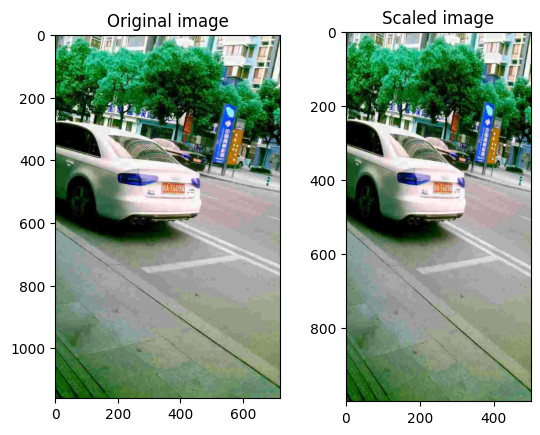

In [50]:
#Plot both the scaled and the original image
some_img = cv2.imread(batch[2][0])
image = batch[0][0]

scaledLabels = batch[1][0]


plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(cv2.imread(batch[2][0]))
axarr[0].set_title("Original image")
axarr[1].imshow(image)
axarr[1].set_title("Scaled image")

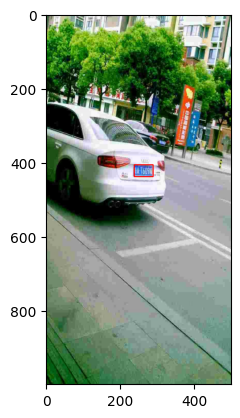

In [51]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def plot_img_and_boundingbox(image, labels):
    numpy_array = image.cpu().detach().numpy()

    cv2_image = cv2.cvtColor(numpy_array, cv2.COLOR_RGB2BGR)

    # Extract numerical values from tensors and convert to integers
    leftUp = (int(labels[0]),int(labels[1]))
    rightDown = (int(labels[2]),int(labels[3]))
    # Draw rectangle on the image
    new_image = cv2.rectangle(cv2_image, leftUp, rightDown, (255, 0, 0), 2)

    # Display the image
    plt.imshow(new_image)
    plt.show()

scaled_labels = batch[1][0]
plot_img_and_boundingbox(image, scaled_labels)

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import keras.utils as image_utils
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import numpy as np
from typing import Union



In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.eval()

In [65]:
import torch.nn as nn
net = nn.Sequential(
    nn.Linear(1280, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(1024, out_features=4, bias=True),
)
model.classifier = net

In [66]:
#Sets model to training mode,e this is important for layers that have different functionalities depending on training or eval. for example BatchNorm
model.train()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [56]:
layers_of_classifier = 4
for i, param in enumerate(model.parameters()):
    if i < len(list(model.parameters())) - layers_of_classifier:
        param.requires_grad = False
    else:
        param.requires_grad = True

number_of_layers = len(list(enumerate(model.parameters())))
print(f"Total number of layers is {number_of_layers}")
print(f"Number of pretrained base layers is {number_of_layers - layers_of_classifier}")

Total number of layers is 160
Number of pretrained base layers is 156


In [ ]:
def check_requires_grad():
  for name, param in model.named_parameters(): # Just to check
    if name.startswith('classifier'):
        print(f'Layer {name} - requires_grad: {param.requires_grad}')
    if name.startswith('features'):
        print(f'Layer {name} - requires_grad: {param.requires_grad}')

#check_requires_grad()

In [100]:
# Helper function to calculate loss when training / testing
def calculate_loss(loader):
  total_loss = 0
  total_samples = 0
  for X_batch_, y_batch, img_name in loader:
      X_batch = X_batch_.permute(0,3,1,2).to(device)
      y_batch = y_batch.to(device)
      y_pred = model(X_batch)
      loss = loss_fn(y_pred, y_batch)
      total_loss += loss.item() * len(y_batch)  # Accumulate scaled loss
      total_samples += len(y_batch)  # Accumulate number of samples
  sample_loss = total_loss / total_samples  # Calculate average loss
  return sample_loss

In [127]:
import torch.optim as optim
from tqdm.notebook import tqdm

# Determine hardware
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device: ", device)

# Define dataloader for training
data_loader = labelFpsDataLoader([data_path],(500,1000))
trainloader = DataLoader(data_loader, batch_size=8, shuffle=True, num_workers=1)

# Determine subset?? (mabeto??)
subset = False
subset_data = Subset(data_loader, indices=range(30))
if subset:
  trainloader =DataLoader(subset_data, batch_size=8, shuffle=True, num_workers=1)

# Define dataloader for validation
test_loader = labelFpsDataLoader([test_path],(500,1000))
validationloader = DataLoader(test_loader, batch_size=64, shuffle=True, num_workers=1)

# Define model and hyperparameters
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
model.train()
model.to(device)

# Train
def train_model(test_history, val_history, n_epochs):
  i = 0
  for epoch in tqdm(range(n_epochs)):
    print("epoch:", i)
    for X_batch, y_batch, img_name in tqdm(trainloader):
      X_batch = X_batch.permute(0,3,1,2).to(device) #Needs to have shape [batch_size, channels, height, width]
      y_batch = y_batch.to(device)
      y_pred = model(X_batch)
      loss = loss_fn(y_pred,y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    # In-sample & out-sample loss calculation
    model.eval()  # Switch to evaluation mode to disable features like dropout
    with torch.no_grad():  # Disable gradient calculation to save memory
        # In sample
        in_sample_loss = calculate_loss(trainloader)
        test_history.append(in_sample_loss)
        print(f'Epoch {epoch+1}, In-sample Loss : {in_sample_loss:.4f}')

        # Out sample
        out_sample_loss = calculate_loss(validationloader)
        val_history.append(out_sample_loss)
        print(f'Epoch {epoch+1}, Out-sample Loss: {out_sample_loss:.4f}')
    i += 1

# Train decoder (initial)
decoder_epochs = 2
train_model([],[], decoder_epochs)
print("DECODER TRAINING DONE")

# Unfreeze encoder
for i, param in enumerate(model.parameters()):
  param.requires_grad = True

# Train encoder
test_history = []
val_history = []
n_epochs = 10
train_model(test_history, val_history, n_epochs)





using device:  cuda


  0%|          | 0/2 [00:00<?, ?it/s]

epoch: 0


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 1, In-sample Loss : 2380.4988
Epoch 1, Out-sample Loss: 2621.4728
epoch: 1


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 2, In-sample Loss : 1177.3094
Epoch 2, Out-sample Loss: 1386.9851
DECODER TRAINING DONE


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 1, In-sample Loss : 1085.6893
Epoch 1, Out-sample Loss: 1273.9712
epoch: 1


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 2, In-sample Loss : 1090.6627
Epoch 2, Out-sample Loss: 1321.8741
epoch: 2


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 3, In-sample Loss : 1053.2736
Epoch 3, Out-sample Loss: 1304.6661
epoch: 3


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 4, In-sample Loss : 1061.9235
Epoch 4, Out-sample Loss: 1340.1093
epoch: 4


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 5, In-sample Loss : 958.6159
Epoch 5, Out-sample Loss: 1238.1892
epoch: 5


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 6, In-sample Loss : 955.2702
Epoch 6, Out-sample Loss: 1252.9201
epoch: 6


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 7, In-sample Loss : 1112.4586
Epoch 7, Out-sample Loss: 1444.6045
epoch: 7


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 8, In-sample Loss : 988.8764
Epoch 8, Out-sample Loss: 1360.0501
epoch: 8


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 9, In-sample Loss : 918.6140
Epoch 9, Out-sample Loss: 1255.8456
epoch: 9


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 10, In-sample Loss : 898.7920
Epoch 10, Out-sample Loss: 1304.7020


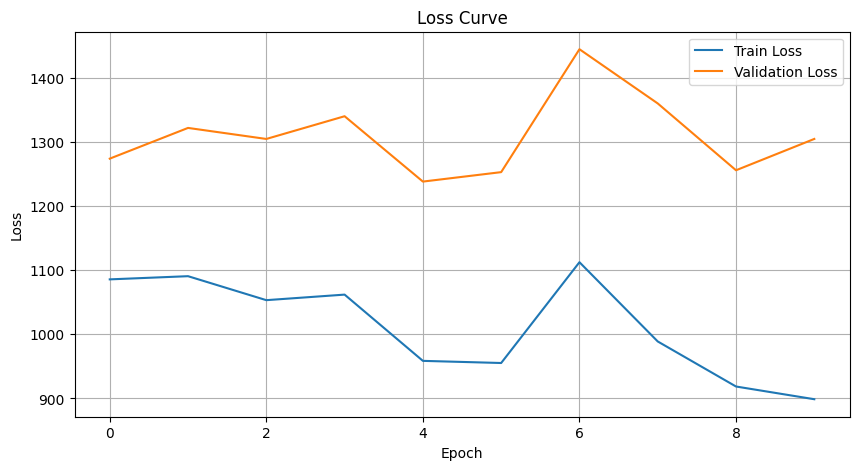

In [128]:
plt.figure(figsize=(10, 5))
#plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.plot(test_history, label='Train Loss')
plt.plot(val_history, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()  # Add a legend to differentiate between train and validation loss
plt.show()

torch.Size([1, 1000, 500, 3])
torch.Size([1, 4])


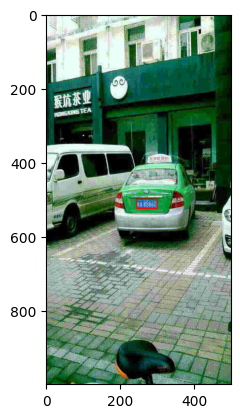

In [129]:
# Print a validation image with its predicted labels

validationloader = DataLoader(test_loader, batch_size=1, shuffle=False, num_workers=1)

validationloader_iter = iter(validationloader)

batch = next(validationloader_iter)

X_batch, y_batch, _ = batch
print(X_batch.shape)
print(y_batch.shape)

image = batch[0][0]
labels = batch[1][0]


plot_img_and_boundingbox(image, labels)

torch.Size([1, 3, 1000, 500])


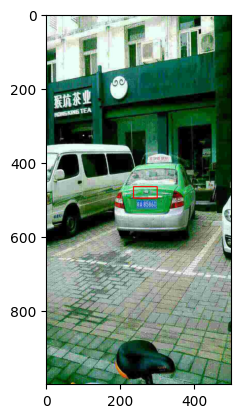

In [130]:
# Getting predicted labels
X_batch = X_batch.permute(0,3,1,2).to(device)
print(X_batch.shape)
pred = model(X_batch)

plot_img_and_boundingbox(image,pred[0])

tensor([[236.9436, 466.8574, 300.8040, 497.9911]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
torch.Size([1, 4])


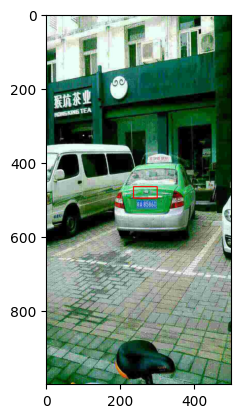

In [131]:
print(pred)
print(pred.shape)
plot_img_and_boundingbox(image,pred[0])